In [ ]:
# Build model using transfer learning MobileNet

In [ ]:
# Requirement Lib Import
import os
import random
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Check GPU support and Get GPU device
from tensorflow.python.client import device_lib 

try:
    print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
    print(device_lib.list_local_devices())
except:
      print('No GPU devices found!')

In [ ]:
# Set default desired model input shape size
INPUT_SIZE = (96, 96)

In [ ]:
# List path locations
BASE_PATH = './dataset'
BASE_DATASET_PATH = os.path.join(BASE_PATH, 'hand-sign-bisindo', 'anoted')
BASE_DATASET_EXT_PATH = os.path.join(BASE_PATH, 'hand-sign-bisindo', 'extracted')

TRAIN_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'train')
VALIDATION_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'val')
TEST_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'test')

In [ ]:
static_labels = os.listdir(TRAIN_DATASET_PATH)
IMG_MIN = 999999

for label in static_labels:
    img_num = len(os.listdir(os.path.join(TRAIN_DATASET_PATH, label)))
    if img_num < IMG_MIN:
        IMG_MIN = img_num
    print('Total TRAINING \'{}\' Images:'.format(label), img_num)

# print('Min size is {}'.format(IMG_MIN))

In [ ]:
# Requirement Lib Import
import math
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Random seed
seed = random.randint(0, IMG_MIN)

# plot matrix size
cols = 3
rows = math.ceil(len(static_labels) / 3)

# Show image plot
fig_size = 3
fig, axs = plt.subplots(rows, cols, figsize = ((fig_size * cols), (fig_size * rows)))
fig.suptitle('Random Selected Trainning Preview')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
axs = axs.ravel()

# Image training random selector
img_dict = {}
for idx, label in enumerate(static_labels):
    img_path = os.path.join(TRAIN_DATASET_PATH, label)
    img_rand = os.listdir(img_path)[seed]
    img_selc = image.load_img(os.path.join(img_path, img_rand))

    axs[idx].imshow(img_selc.resize(INPUT_SIZE))
    axs[idx].set_title(label)

In [ ]:
# Dataset pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    # rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATASET_PATH,
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)

In [ ]:
# defined classes based on foldering structure, sort by alphabetical
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS) # Set classes num
print(NUM_CLASSES)

In [ ]:
# from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
    weights = 'imagenet', 
    input_shape = (INPUT_SIZE[0], INPUT_SIZE[1], 3), 
    include_top = False, 
    pooling = 'avg',
    classifier_activation = None
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# See Pre Trained Model Summary
pre_trained_model.summary()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
# More info about Adam optimzer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation = 'relu')(x)
# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)  

# Re-Create model
model = Model(inputs = pre_trained_model.input, outputs = x)

# Compile Model
model.compile(
    optimizer = Adam(learning_rate = 0.01), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

# Start Training!
history = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    steps_per_epoch = 50,
    epochs = 30, 
    validation_steps = 10,
    verbose = 1
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [ ]:
def selectRandomImage(labels = None):
    if labels == None:
        seed = random.randint(1, NUM_CLASSES)
        label_seed = LABELS[seed - 1]
    else:
        seed = random.randint(1, len(labels))
        label_seed = labels[seed - 1]
    
    path = os.path.join(TEST_DATASET_PATH, label_seed)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label_seed)

In [ ]:
def createResultPlot(prediction_list, prediction_label, actual_label, file_name):
    # Result Plot
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle('Image {} predict as: {}'.format(file_name, prediction_label))
    fig.subplots_adjust(top = 0.95)
    fig.tight_layout()
    axs = axs.ravel()

    # See other color refrences: https://xkcd.com/color/rgb/
    if prediction_label == actual_label:
        #If prediction True
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        #If prediction False
        fig.patch.set_facecolor('xkcd:pale pink')

    # Show selected image
    axs[0].set_title(actual_label)
    axs[0].imshow(img)

    # Prediction Probabilities Plot
    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, NUM_CLASSES), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, NUM_CLASSES))
    axs[1].set_xticklabels(LABELS)

    plt.show()

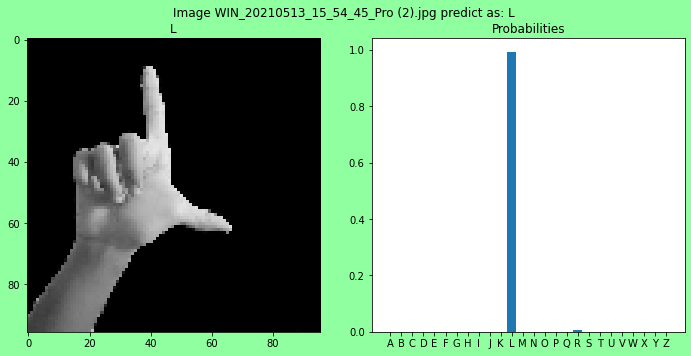

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# predicting images
# file_path, file_name, label = selectRandomImage()
file_path, file_name, label = selectRandomImage(['L'])
img = image.load_img(file_path, target_size = INPUT_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

prediction = model.predict(x, batch_size = 10) # Predict Image
index = int(prediction[0].argmax(axis = -1)) # Get max classes index

# Result Plot
createResultPlot(prediction[0].reshape(NUM_CLASSES), LABELS[index], label, file_name)

In [ ]:
static_labels = os.listdir(TRAIN_DATASET_PATH)
IMG_TEST_MIN = 999999

for label in LABELS:
    img_num = len(os.listdir(os.path.join(TEST_DATASET_PATH, label)))
    if img_num < IMG_TEST_MIN:
        IMG_TEST_MIN = img_num
    print('Total TESTING \'{}\' Images:'.format(label), img_num)

# print('Min size is {}'.format(IMG_MIN))

In [ ]:
# Create confussion matrix to all label in test dir
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix

# Variable storing pred
y_true = [] # Actual 
y_pred = [] # Pediction

for label in LABELS:
    # Get iamges
    path = os.path.join(TEST_DATASET_PATH, label)
    files = os.listdir(path)
    for idx, file_name in enumerate(files):
        if idx < IMG_TEST_MIN:
            file_loc = os.path.join(path, file_name)
            img = image.load_img(file_loc, target_size = INPUT_SIZE)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis = 0)
            x = preprocess_input(x)

            prediction = model.predict(x) # Predict Image
            index = int(prediction[0].argmax(axis = -1)) # Get max classes index
            y_true.append(label)
            y_pred.append(LABELS[index])
        else:
            break

mat = confusion_matrix(y_true, y_pred, labels = LABELS)

Total testing: 11


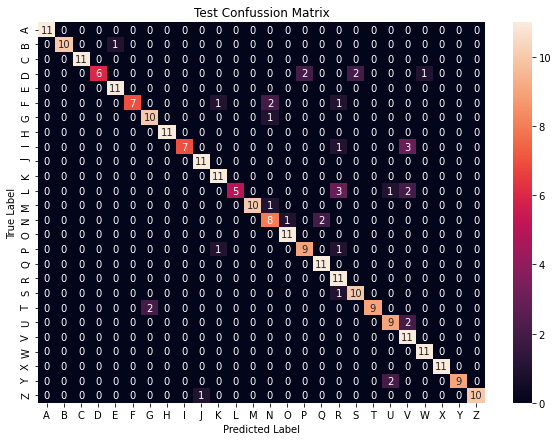

In [57]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

print('Total testing: {}'.format(IMG_TEST_MIN))
df_cm = pd.DataFrame(mat, index = LABELS, columns = LABELS)

plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot = True)
ax.set_title("Test Confussion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

In [ ]:
# Save model
model.save(os.path.join(os.getcwd(), 'models','hand-sign-bisindo-model-mobilenet(96x96).h5'))